In [66]:
from typing import List, Optional
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp, shapiro, ttest_ind, mannwhitneyu, chi2_contingency, ttest_rel
from statsmodels.stats.weightstats import zconfint

from sklearn.metrics import roc_auc_score, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score, train_test_split, ShuffleSplit
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb
%matplotlib inline

# убираем лишние замечания интерпретатора
import warnings
warnings.simplefilter('ignore')

# import additional packages for WOE/IV
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string
# глобальные переменные WOE/IV
max_bin = 20
force_bin = 3

In [2]:
# функции метода WOE/IV

def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]    
    df2 = notmiss.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]      
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [141]:
train = pd.read_csv("./dataset/train.csv")
test = pd.read_csv("./dataset/test.csv")


X_train = train.copy()
#X_train = X_train.drop('isFraud', axis = 1)
X_train.set_index('TransactionID')
X_test = test.copy()
#X_test = X_test.drop('isFraud', axis = 1)
X_train.set_index('TransactionID')

print("X_train.shape = {} rows, {} cols".format(*X_train.shape))
print("X_test.shape = {} rows, {} cols".format(*X_test.shape))

X_train.shape = 50001 rows, 394 cols
X_test.shape = 75000 rows, 394 cols


In [ ]:
X_train, X_test = train_test_split(
    data.drop(["ID"], axis=1), train_size=0.75, shuffle=True, random_state=1,
)
y_train, y_test = train_test_split(
    data["y"], train_size=0.75, shuffle=True, random_state=1,
)

In [ ]:
X_train.describe()

In [ ]:
X_test.describe()

Предварительный вывод: распределения в трейне и тесте похожи, часть фич не отображается - не цифровые фичи (14)

## Анализ числовых переменных

In [4]:
numerical_features = X_train.select_dtypes(include=[np.number])
print(f"count of numeric_features {numerical_features.shape[1]}")

numerical_features.columns

count of numeric_features 380


Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=380)

вывод: 379 фич из 393 - цифровые

In [ ]:
numerical_features.head()

###### Выявление дискретных признаков

In [5]:
discrete_feature = [
    feature for feature in numerical_features
    if len(X_train[feature].unique())<25
]
print(f"Discrete Variables Count: {len(discrete_feature)}")

Discrete Variables Count: 220


220 фич из 380 - дискретные

Постараемся найти зависимость между дескретными признаками и целевой переменной

In [ ]:
fig, axes = plt.subplots(100, 4, figsize=(25, 400))

for num, feature in enumerate(discrete_feature):
    data = train.copy()
    statistics = data.groupby([feature])["isFraud"].median()

    sns.barplot(
        x=statistics.index,
        y=statistics.values,
        palette="viridis",
        ax=axes[num%100, num//100]
    )

Итоги: у некоторых фич можно объединить значения в одно, например у V116
из V123 можно сделать бинарную фичу, объединив данные от 4 до 10 в "1", а остальные приравняв "0"
Т.О. большое количество фич можно преобразовать в бинарные (или создать бинарные на их основе


In [ ]:
X_train['isFraud'].unique()

целевой признак- бинарная переменная 

###### Непрерывные признаки

In [6]:
continuous_feature = [
    feature for feature in numerical_features
    if feature not in discrete_feature
]

print(f"Continuous Feature Count {len(continuous_feature)}")

Continuous Feature Count 160


160 признаков - непрерывные, включая TransactionID

Для непрерывные признаков имеет смысл строить гистрограммы распределения или функции распределения, а также зависимость непрерывного признака в разрезе целевой переменной. Кроме того, имеет смысл строить распределение __одновременно__ и для обучающей выборки, и для тестовой для понимания насколько отличаются распределения.

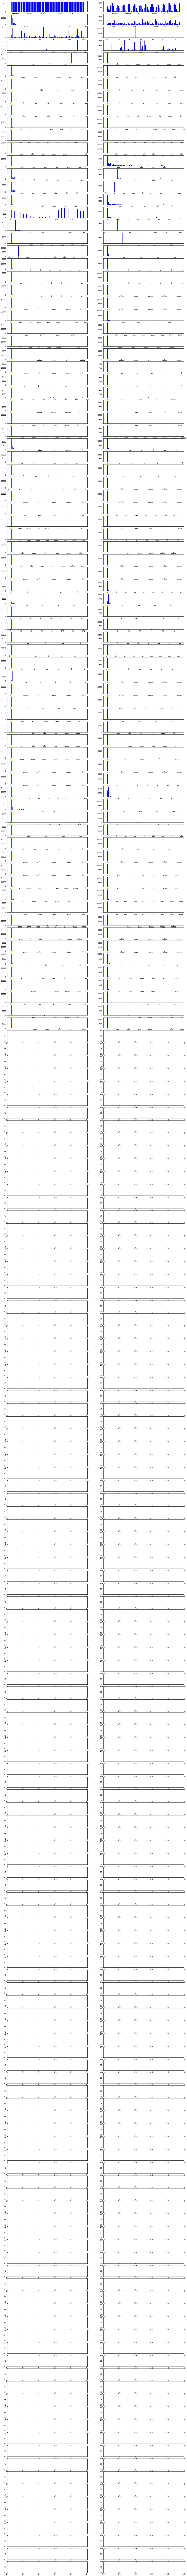

In [81]:
# гистограммы распределения признаков:

fig, axes = plt.subplots(200, 2, figsize=(20, 300))

for num, feature in enumerate(continuous_feature):
    data = train[feature].copy()
    axes[num//2, num%2].hist(data, bins=100, color="blue", ec='white')
    axes[num//2, num%2].set_xlabel(feature, fontsize=10)

Вывод: все распределения ненормальны, часто имеются скосы, у большинства фич есть выбросы в нуле, что свидетельствует или о предобработке или о том, что события редко встречаются.
Требуется дополнительный анализ
Вывод: нужно выкидывать следующие признаки, у которых распределение не совпадает в трейне и тесте: с2, с4, с5, с6, с8, с10, с12. с13, d8, d9, d14, v99, v129, v145,150,159,160,161,162,166,168,178,221,266,285,310, 312

Text(0.5, 0, 'TransactionDT')

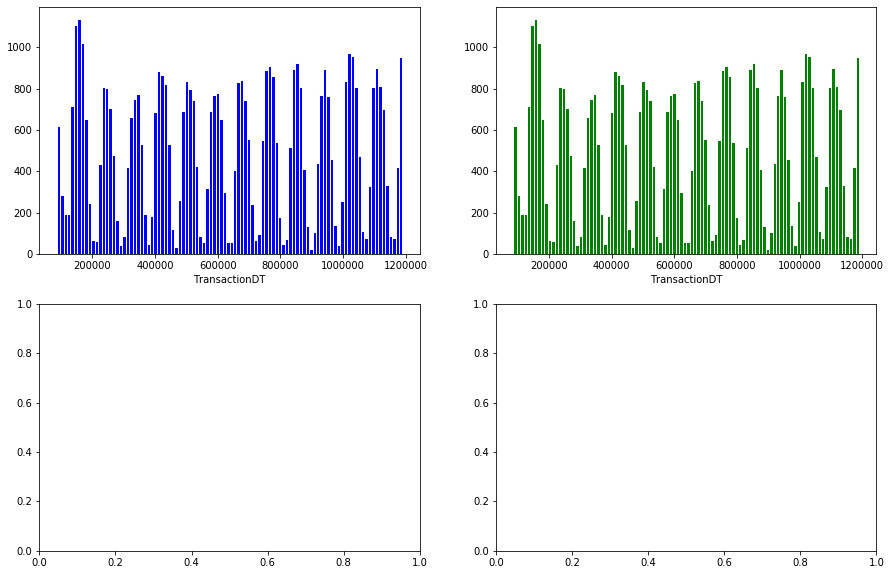

In [14]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
data_train = train['TransactionDT'].copy()
data_test = train['TransactionDT'].copy()
axes[0, 0].hist(data_train, bins=100, color="blue", ec='white')
axes[0, 0].set_xlabel('TransactionDT', fontsize=10)
axes[0, 1].hist(data_test, bins=100, color="green", ec='white')
axes[0, 1].set_xlabel('TransactionDT', fontsize=10)

вывод: train and test взяты из одного сета - информации по транзакциям за 12 суток,
    соответственно в них есть зависимости по записям. Нет инфы о клиент id, т.о. транзакции
    одного клиента будут и в трейне и в тесте

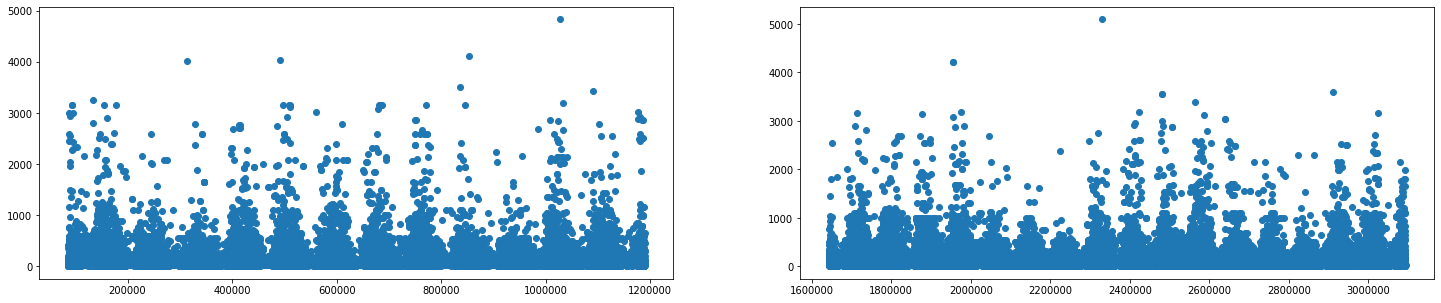

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=2)
ax1, ax2 = ax
ax1.scatter(train["TransactionDT"], train["TransactionAmt"])
ax2.scatter(test["TransactionDT"], test["TransactionAmt"])
fig.set_size_inches(25, 5)

по результатам видим, что по величине транзакции по DT - разное распределение, на трене - 12 дней, на тесте 18, из-за разницы в количестве данных в трейне и тесте

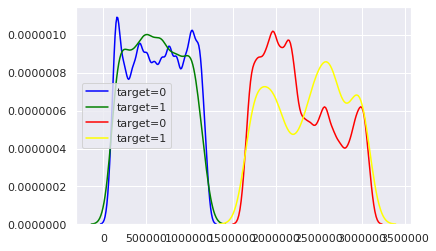

In [84]:
feature = "TransactionDT"

feature_with_target_s = train[[feature, 'isFraud']].sample(50000)
feature_s = feature_with_target_s[feature]
feature_target_0 = feature_s[feature_with_target_s['isFraud'] == 0]
feature_target_1 = feature_s[feature_with_target_s['isFraud'] == 1]
sns.kdeplot(feature_target_0, color="blue", label="target=0")
sns.kdeplot(feature_target_1, color="green", label="target=1")
feature_with_target_s_ = test[[feature, 'isFraud']].sample(75000)
feature_s_ = feature_with_target_s_[feature]
feature_target_0_ = feature_s_[feature_with_target_s_['isFraud'] == 0]
feature_target_1_ = feature_s_[feature_with_target_s_['isFraud'] == 1]
sns.kdeplot(feature_target_0_, color="red", label="target=0")
sns.kdeplot(feature_target_1_, color="yellow", label="target=1")

Выводы: для TransactionDT распределения в тесте и трейне крайне разные, что может
    привести к проблемам

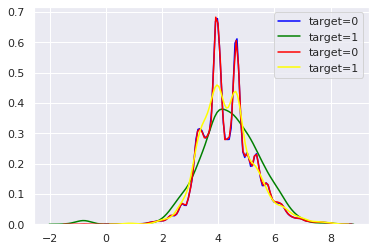

In [85]:
feature = "TransactionAmt"

feature_with_target_s = train[[feature, 'isFraud']].sample(50000)
feature_s = feature_with_target_s[feature]
feature_target_0 = feature_s[feature_with_target_s['isFraud'] == 0]
feature_target_1 = feature_s[feature_with_target_s['isFraud'] == 1]
sns.kdeplot(np.log(feature_target_0), color="blue", label="target=0")
sns.kdeplot(np.log(feature_target_1), color="green", label="target=1")
feature_with_target_s_ = test[[feature, 'isFraud']].sample(75000)
feature_s_ = feature_with_target_s_[feature]
feature_target_0_ = feature_s[feature_with_target_s_['isFraud'] == 0]
feature_target_1_ = feature_s[feature_with_target_s_['isFraud'] == 1]
sns.kdeplot(np.log(feature_target_0_), color="red", label="target=0")
sns.kdeplot(np.log(feature_target_1_), color="yellow", label="target=1")

для TransactionAmt мы видим более-менее совпадающие распределения в тесте и трейне,
разница в распределениях для 0 и 1 связано видимо с малым количеством данных по 1,,
скажем так - фрод хорошо маскируется по величине денег в транзакциях под норм (небольшие) транзакции

###### Категориальные признаки

In [80]:
categorical_features = X_train.select_dtypes(include='object')
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.head()

Categorical Feature Count 14


ProductCD       card4   card6 P_emaildomain R_emaildomain   M1   M2   M3  \
0         W    discover  credit           NaN           NaN    T    T    T   
1         W  mastercard  credit     gmail.com           NaN  NaN  NaN  NaN   
2         W        visa   debit   outlook.com           NaN    T    T    T   
3         W  mastercard   debit     yahoo.com           NaN  NaN  NaN  NaN   
4         H  mastercard  credit     gmail.com           NaN  NaN  NaN  NaN   

    M4   M5   M6   M7   M8   M9  
0   M2    F    T  NaN  NaN  NaN  
1   M0    T    T  NaN  NaN  NaN  
2   M0    F    F    F    F    F  
3   M0    T    F  NaN  NaN  NaN  
4  NaN  NaN  NaN  NaN  NaN  NaN

In [122]:
X_train['ProductCD'].unique()

array([0, 1, 2, 3, 4])

In [ ]:
X_train['ProductCD'] = X_train['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(int)

In [ ]:
X_test['ProductCD'] = X_test['ProductCD'].map({'W':'0', 'H':'1', 'C':'2', 'S':'3', 'R':'4'}).astype(int)

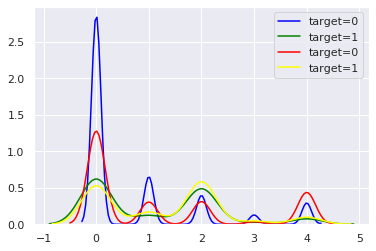

In [126]:
feature = "ProductCD"

feature_with_target_s = X_train[[feature, 'isFraud']].sample(50000)
feature_s = feature_with_target_s[feature]
feature_target_0 = feature_s[feature_with_target_s['isFraud'] == 0]
feature_target_1 = feature_s[feature_with_target_s['isFraud'] == 1]
sns.kdeplot(feature_target_0, color="blue", label="target=0")
sns.kdeplot(feature_target_1, color="green", label="target=1")
feature_with_target_s_ = X_test[[feature, 'isFraud']].sample(75000)
feature_s_ = feature_with_target_s_[feature]
feature_target_0_ = feature_s_[feature_with_target_s_['isFraud'] == 0]
feature_target_1_ = feature_s_[feature_with_target_s_['isFraud'] == 1]
sns.kdeplot(feature_target_0_, color="red", label="target=0")
sns.kdeplot(feature_target_1_, color="yellow", label="target=1")

распределение ProductCD разное для цели=0 для теста и трейна, цель=1 почти одинакова в трейне и тесте

X_train['card6'].unique()

In [143]:
X_train['card6'] = X_train['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)

In [144]:
X_test['card6'] = X_test['card6'].map({'credit':'0', 'debit':'1', 'debit or credit':'2', 'charge card':'3', 'nan':'4'}).astype(float)

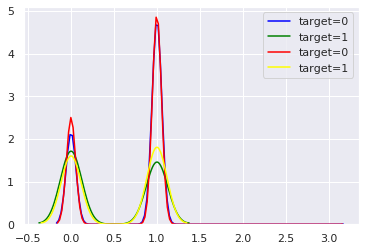

In [145]:
feature = "card6"

feature_with_target_s = X_train[[feature, 'isFraud']].sample(50000)
feature_s = feature_with_target_s[feature]
feature_target_0 = feature_s[feature_with_target_s['isFraud'] == 0]
feature_target_1 = feature_s[feature_with_target_s['isFraud'] == 1]
sns.kdeplot(feature_target_0, color="blue", label="target=0")
sns.kdeplot(feature_target_1, color="green", label="target=1")
feature_with_target_s_ = X_test[[feature, 'isFraud']].sample(75000)
feature_s_ = feature_with_target_s_[feature]
feature_target_0_ = feature_s_[feature_with_target_s_['isFraud'] == 0]
feature_target_1_ = feature_s_[feature_with_target_s_['isFraud'] == 1]
sns.kdeplot(feature_target_0_, color="red", label="target=0")
sns.kdeplot(feature_target_1_, color="yellow", label="target=1")

распределения более менее совпадают

X_train['card4'].unique()

In [153]:
X_train['card4'] = X_train['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

In [154]:
X_test['card4'] = X_test['card4'].map({'discover':'0', 'mastercard':'1', 'visa':'2', 'american express':'3', 'nan':'4'}).astype(float)

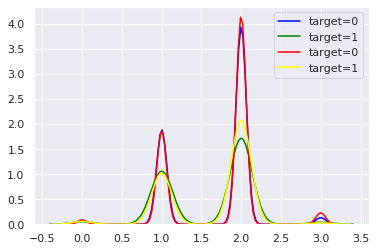

In [155]:
feature = "card4"

feature_with_target_s = X_train[[feature, 'isFraud']].sample(50000)
feature_s = feature_with_target_s[feature]
feature_target_0 = feature_s[feature_with_target_s['isFraud'] == 0]
feature_target_1 = feature_s[feature_with_target_s['isFraud'] == 1]
sns.kdeplot(feature_target_0, color="blue", label="target=0")
sns.kdeplot(feature_target_1, color="green", label="target=1")
feature_with_target_s_ = X_test[[feature, 'isFraud']].sample(75000)
feature_s_ = feature_with_target_s_[feature]
feature_target_0_ = feature_s_[feature_with_target_s_['isFraud'] == 0]
feature_target_1_ = feature_s_[feature_with_target_s_['isFraud'] == 1]
sns.kdeplot(feature_target_0_, color="red", label="target=0")
sns.kdeplot(feature_target_1_, color="yellow", label="target=1")

распределения более менее совпадают

## Анализ пропусков

In [ ]:
msno.matrix(X_train, figsize=(20, 5))

очень много пропусков

In [ ]:
features_with_na = [
    feature for feature in X_train.columns
    if X_train[feature].isnull().sum() > 1]

fig, axes = plt.subplots(100, 4, figsize=(30, 400))
for num, feature in enumerate(features_with_na):
    data = train.copy()
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    statistics = data.groupby(feature)["isFraud"].median()
    axes[num%100, num//100].bar(statistics.index, statistics.values)
    axes[num%100, num//100].set_xticks([0, 1])
    axes[num%100, num//100].set_xticklabels(["no missing", "missing"])
    axes[num%100, num//100].set_ylabel(feature)

In [ ]:
Итого: у следующих признаков имеются различия в распределениях в зависимости от присутствия и отсутствия значений:
        card3 и card6,можно сгенерировать новые признаки на этой основе

In [ ]:
missing_values = categorical_features.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']>25000]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
fig, axes = plt.subplots(figsize=(8, 4))
rects = axes.barh(ind, missing_values.missing_count.values, height=0.9)
axes.set_yticks(ind)
axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
axes.set_title("Missing Observations Count - Categorical Features")
axes.set_xlabel("Missing Observations Count")

Если отбросить по принципу 50%, то нужно отбросить: M4, M1, M2, M3, M5, R_emaildomain, M7, M8, M9

In [ ]:
missing_values = numerical_features.isnull().sum(axis=0).reset_index()
missing_values.columns = ['column_name', 'missing_count']
missing_values = missing_values.loc[missing_values['missing_count']<50000]
missing_values = missing_values.sort_values(by='missing_count')

ind = np.arange(missing_values.shape[0])
fig, axes = plt.subplots(figsize=(8, 80))
rects = axes.barh(ind, missing_values.missing_count.values, height=0.9)
axes.set_yticks(ind)
axes.set_yticklabels(missing_values.column_name.values, rotation='horizontal')
axes.set_title("Missing Observations Count - Categorical Features")
axes.set_xlabel("Missing Observations Count")

In [ ]:
Если отбросить по принципу 50%, то нужно отбросить 183 фичи, практически половину

###### Анализ "скошенности" распределений:

In [ ]:
fig = plt.figure(figsize=(150, 5))
train_stats, test_stats = X_train.skew(), X_test.skew()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.xlim(0, len(train_stats))
plt.ylabel("skew", size=15)
plt.show()

In [ ]:
Кандидаты на удаление: adr2, c3, c7, c12, v1, v14, v27,28,68,89,117,118,119,126,128,135,136,137,202,204,214,215,216,221,222,
    226,240,241,263,276,277,278,305,306,319,320,321

In [ ]:
fig = plt.figure(figsize=(150, 5))
train_stats, test_stats = X_train.kurtosis(), X_test.kurtosis()
plt.plot(train_stats, color="blue", label="train")
plt.plot(test_stats, color="green", label="test")
plt.xticks(range(train_stats.shape[0]), train_stats.index, rotation=90)
plt.xlabel("features", size=15)
plt.ylabel("kurtosis", size=15)
plt.xlim(0, len(train_stats))
plt.show()

Кандидаты на удаление: adr2, c3, c7, c12, v1, v27,28,68,89,117,118,119,126,128,135,136,137,202,204,214,215,216,221,222,
    226,240,241,263,276,277,278,305,306,319,320,321

## Анализ распределения целевой переменной

###### Проверка баланса классов цели¶

In [ ]:
X_train['isFraud'].value_counts()

In [ ]:
plt.figure(figsize=(4, 2))

sns.countplot(x='isFraud', data=X_train)

plt.title('Target variable distribution')
plt.show()

Вывод: крайне сильный дисбаланс, надо делать балансировку

### Для дальнейшего изучения взаимосвязи признаков будем использовать:
* Correlation Heat Map
* Heat Map для отдельных признаков
* Pair Plot
* Scatter Plot

## Корреляция между числовыми признаками

построим график зависимости количества коррелированных признаков от уровня кореляции (признаков с уровнем кореляции выше чем уровень корреляции на этом шаге) 

In [ ]:
correlation = numerical_features.corr()
x = []
y = []
i = 0.01
while i < 0.2:
    x.append(len(correlation.loc[(correlation["isFraud"] > i)|(correlation["isFraud"] < -i), "isFraud"]))
    y.append(i)
    i += 0.01
plt.scatter(y,x)
plt.show()

Вывод: выбор фич по уровню 0.2 в данном случае не подходит, тк. имеет место зависимость, близкая к линейной - не очень хорошая идея отбрасывать много коррелированных фич

In [ ]:
# Тепловая карта - получаем информацию о силе связи между переменными.
fig, axes = plt.subplots(figsize = (50,50))
plt.title("Correlation of Numeric Features with isFraud", y=1, size=16)
sns.heatmap(correlation, square=True, vmax=0.8, cmap="viridis")

In [ ]:
Многие фичи очень сильно коррелированы друг с другом, можно подумать об удалении части из них

In [ ]:
msno.heatmap(X_train, figsize=(200, 120))

Присутствует мощнейшая кореляция, после анализа, выводы - следующие диапазоны можно
заменить одним признаком:
    - M1,M2,dist1
    - D9,D8
    - adr1,adr2
    - card2,card6
    - M7,M8
    - V1-V10
    - V12-V33
    - V35-V51
    - V53-V73
    - V75-V93
    - V138-V165
    - V167-V277
    - V279-V320
    - V322-V339

###### теперь посмотрим в сравнении трейн и тест:

In [ ]:
train_correlations = numerical_features.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = numerical_features.columns.tolist()
columns.remove("isFraud")

test_correlations = X_test[columns].corr()
test_correlations = test_correlations.values.flatten()
test_correlations = test_correlations[test_correlations != 1]

plt.figure(figsize=(20,5))
sns.distplot(train_correlations, color="Blue", label="train")
sns.distplot(test_correlations, color="Green", label="test")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)

трейн и тест более менее одинаково показывают линейную корреляцию фичей к цели -> трейн и тест из одного сета,
модель должна быть стабильна в логистической регрессии

## Pair Plot

PairPlor между `target` и высоко-коррелированными переменными. Строим этот график для лучшего понимания характерика связи между целевой переменной и признаком. С помощью корреляционной матрицы мы установили что связь между определенными признаками и целевой переменной есть, но характер этой связи пока остается невыясненным. Строим PairPlot для лучшего понимания характера этой связи;

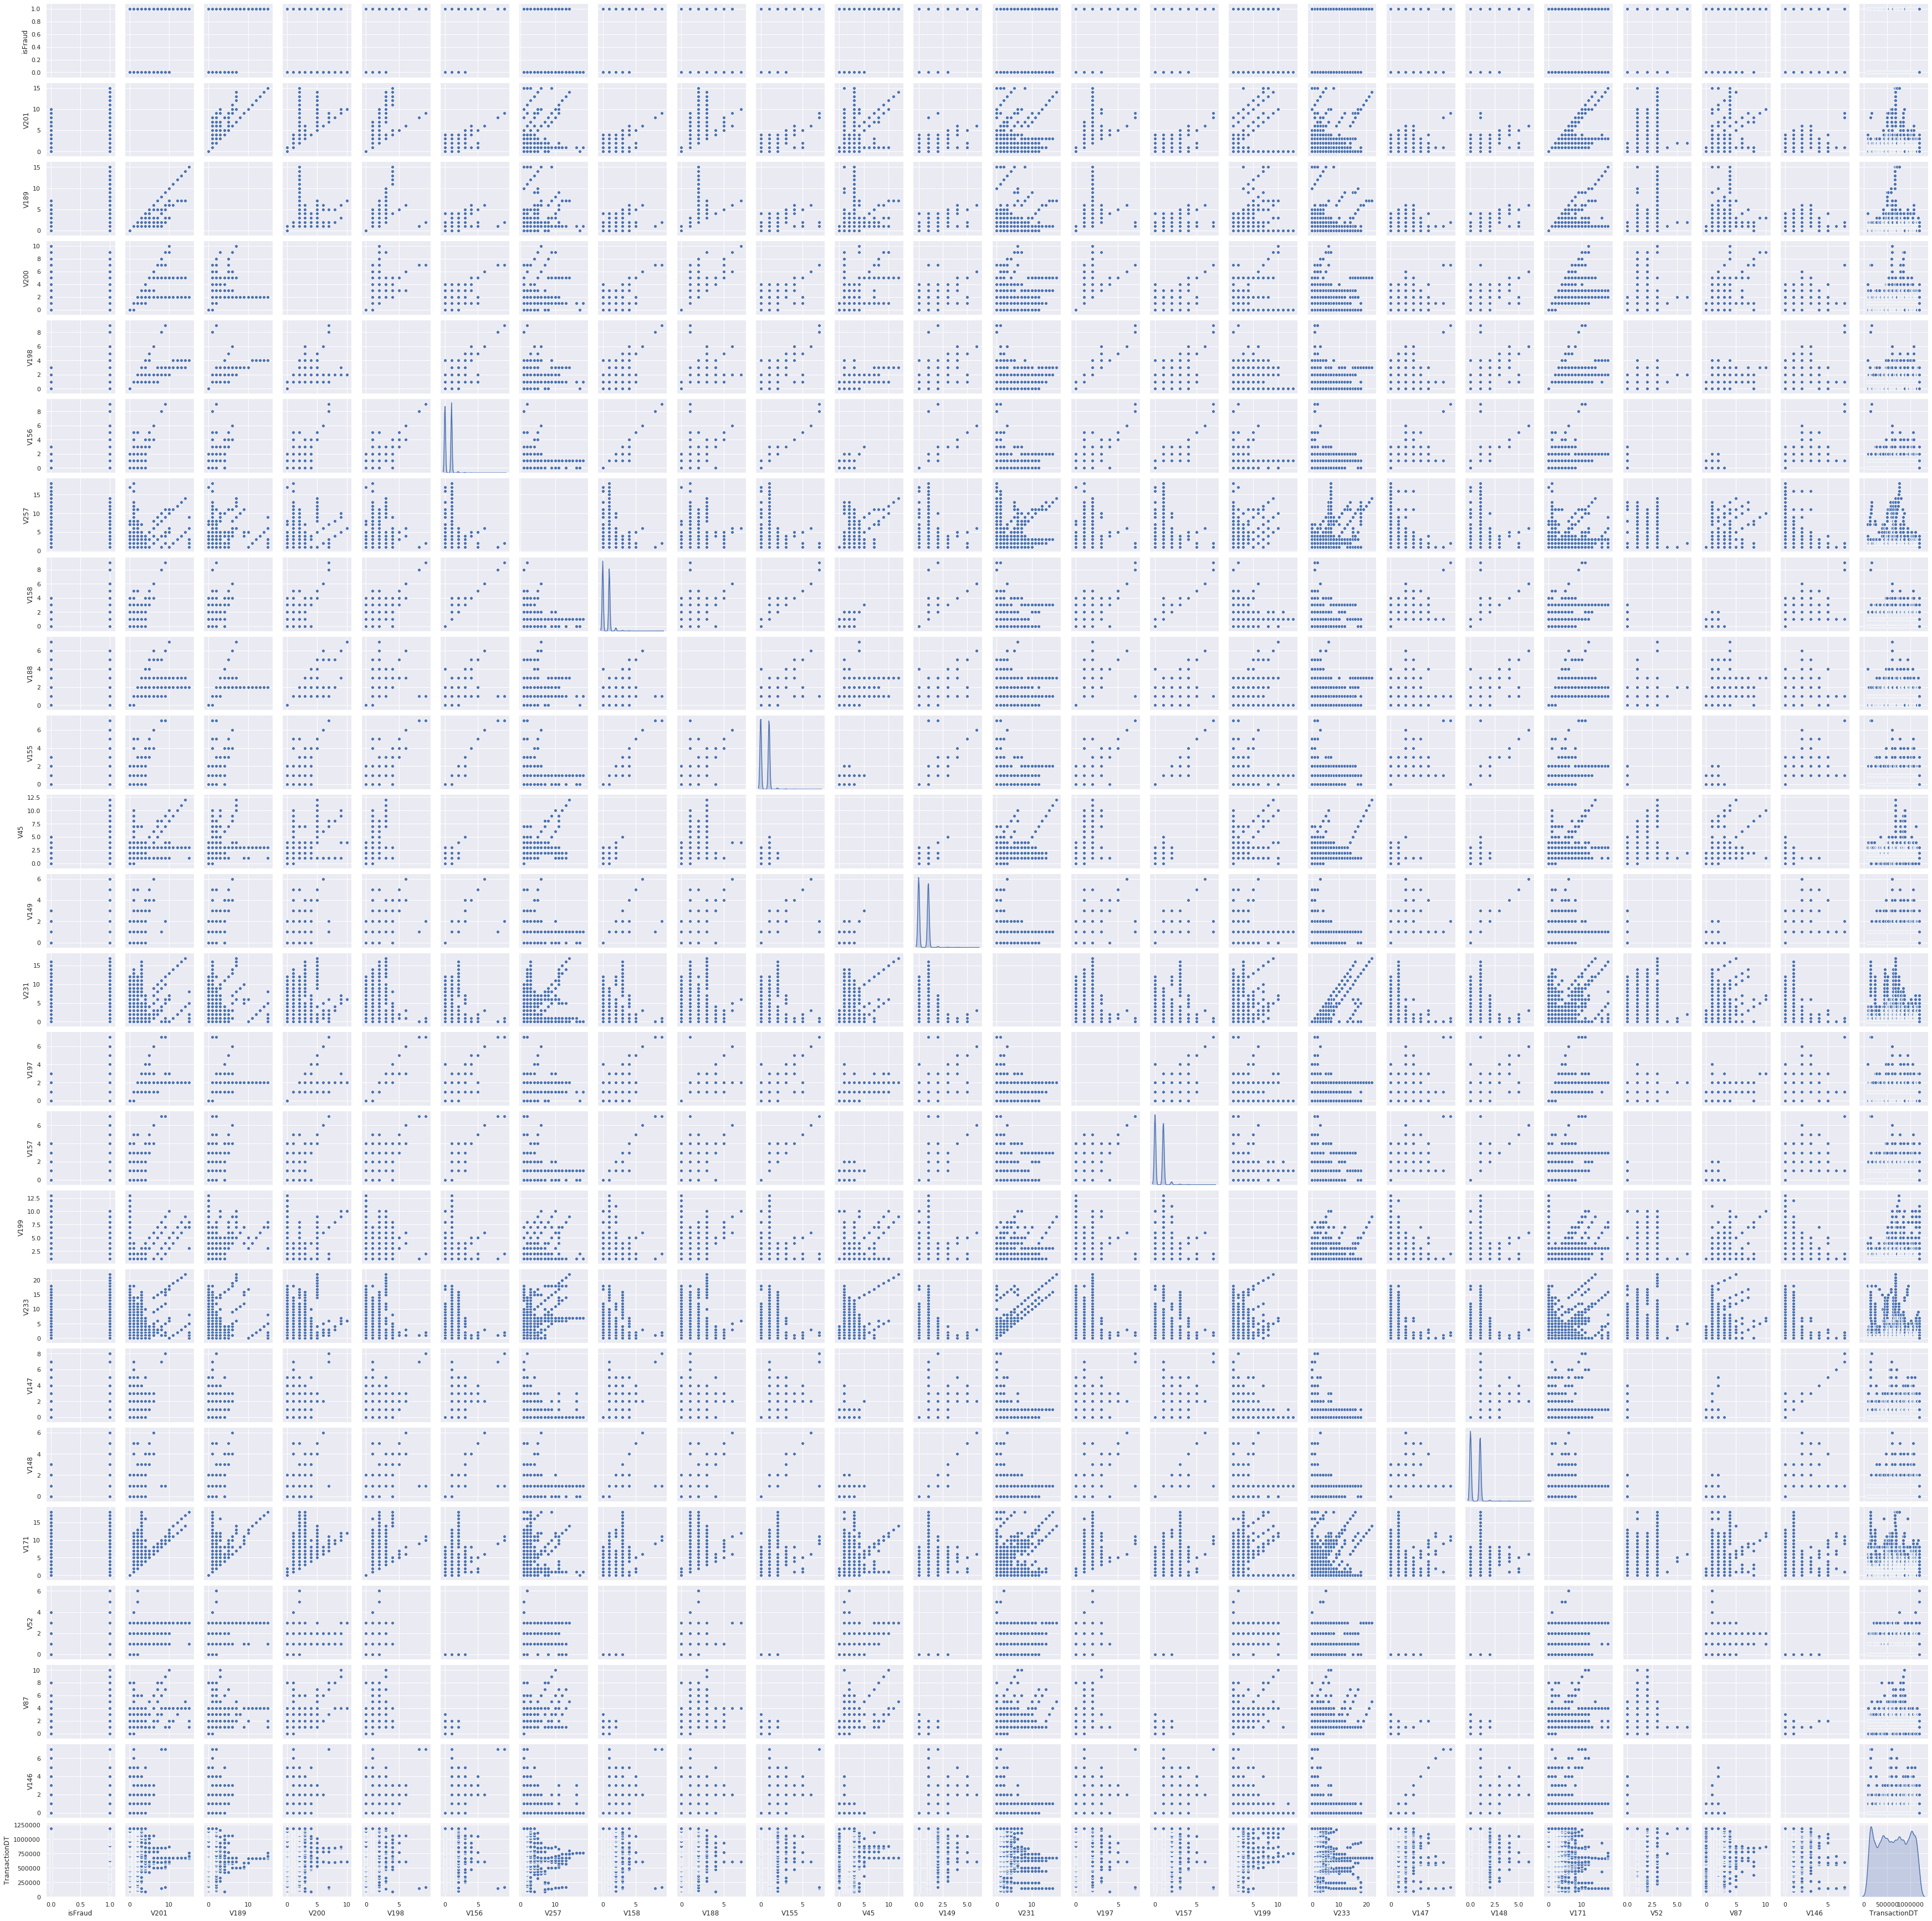

In [27]:
sns.set()
columns = [
    "isFraud", "V201", "V189", "V200", "V198", "V156",
    "V257", "V158", "V188", "V155", "V45", "V149", "V231", "V197",
    "V157", "V199", "V233", "V147", "V148", "V171", "V52", "V87", "V146", "TransactionDT"
]

sns.pairplot(X_train[columns], size=2, kind="scatter", diag_kind="kde")
plt.show()


__Короткий анализ:__

Существует много линейных зависимости между фиами
Существует много линейных границ между фичами, выше или ниже которых другая фича не идёт


###### Теперь оценим фичи по методу WOE/IV (выбираем в диапазоне от 0.1 до 0.5)


In [ ]:
final_iv, IV = data_vars(X_train, X_train['isFraud']) # вычисление уровней IV (Information Values) метода WOE по фичам

In [ ]:
IV.loc[(IV['IV'] > 0.1), :].sort_values('IV')

Итак, у нас 184 значимых фичи из 379. При этом, M4, C12, R_emaildomain - слишком хороши, чтобы остаться в пуле, тем более ранее мы их определили кандидатами на выбывание, остаётся 181 фича, по графику корреляции это соответствует уровню 0.065, сравним эти 2 списка

In [ ]:
df_correlation=pd.DataFrame(correlation.loc[(correlation["isFraud"] > 0.065)|(correlation["isFraud"] < -0.065), "isFraud"])

In [ ]:
df_correlation.to_csv('df_correlation.csv', sep=';')
IV.loc[(IV['IV'] > 0.1), :].sort_values('IV').to_csv('IV.csv', sep=';', index=False)

После обработки в Excel (слияние, удаление дубликатов, удаление излишеих фич после анализа корреляции):

In [33]:
df_merge_cut = pd.read_csv('merge_cut.csv', sep=';').to_numpy().flatten()
df_merge_cut

array(['addr1', 'C1', 'C10', 'C11', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8',
       'card3', 'D12', 'D13', 'D14', 'D15', 'D2', 'D3', 'D5', 'D6', 'D7',
       'D9', 'dist2', 'M3', 'M6', 'P_emaildomain', 'ProductCD', 'V101',
       'V102', 'V103', 'V108', 'V109', 'V110', 'V111', 'V112', 'V113',
       'V114', 'V115', 'V116', 'V117', 'V118', 'V119', 'V120', 'V121',
       'V122', 'V123', 'V124', 'V125', 'V126', 'V128', 'V132', 'V133',
       'V134', 'V15', 'V150', 'V200', 'V290', 'V40', 'V60', 'V7', 'V85',
       'V95', 'V97'], dtype=object)

In [34]:
X = train['isFraud']
for i in range(0,62):
    X = pd.concat([X, train[df_merge_cut[i]]], axis=1)
X.head()

isFraud  addr1   C1  C10  C11   C2   C4   C5   C6   C7  ...  V15    V150  \
0        0  315.0  1.0  0.0  2.0  1.0  0.0  0.0  1.0  0.0  ...  0.0     NaN   
1        0  325.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...  0.0     NaN   
2        0  330.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...  0.0     NaN   
3        0  476.0  2.0  0.0  1.0  5.0  0.0  0.0  4.0  0.0  ...  0.0     NaN   
4        0  420.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  ...  NaN  1803.0   

   V200  V290  V40  V60   V7  V85  V95   V97  
0   NaN   1.0  NaN  0.0  1.0  0.0  0.0   0.0  
1   NaN   1.0  0.0  0.0  NaN  0.0  0.0   0.0  
2   NaN   1.0  0.0  0.0  1.0  0.0  0.0   0.0  
3   NaN   1.0  0.0  0.0  NaN  0.0  1.0  28.0  
4   1.0   1.0  NaN  NaN  NaN  NaN  0.0   0.0  

[5 rows x 63 columns]

In [35]:
X = test['isFraud']
for i in range(0,62):
    X = pd.concat([X, train[df_merge_cut[i]]], axis=1)
X.head()

isFraud  addr1   C1  C10  C11   C2   C4   C5   C6   C7  ...  V15    V150  \
0        0  315.0  1.0  0.0  2.0  1.0  0.0  0.0  1.0  0.0  ...  0.0     NaN   
1        1  325.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...  0.0     NaN   
2        0  330.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  ...  0.0     NaN   
3        0  476.0  2.0  0.0  1.0  5.0  0.0  0.0  4.0  0.0  ...  0.0     NaN   
4        0  420.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  ...  NaN  1803.0   

   V200  V290  V40  V60   V7  V85  V95   V97  
0   NaN   1.0  NaN  0.0  1.0  0.0  0.0   0.0  
1   NaN   1.0  0.0  0.0  NaN  0.0  0.0   0.0  
2   NaN   1.0  0.0  0.0  1.0  0.0  0.0   0.0  
3   NaN   1.0  0.0  0.0  NaN  0.0  1.0  28.0  
4   1.0   1.0  NaN  NaN  NaN  NaN  0.0   0.0  

[5 rows x 63 columns]

In [46]:
X_tr = train[df_merge_cut[0]]
for i in range(1,62):
    X_tr = pd.concat([X_tr, train[df_merge_cut[i]]], axis=1)

X_tr = X_tr.select_dtypes(include=[np.number])
X_tr.head()

addr1   C1  C10  C11   C2   C4   C5   C6   C7   C8  ...  V15    V150  V200  \
0  315.0  1.0  0.0  2.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0     NaN   NaN   
1  325.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0     NaN   NaN   
2  330.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0     NaN   NaN   
3  476.0  2.0  0.0  1.0  5.0  0.0  0.0  4.0  0.0  0.0  ...  0.0     NaN   NaN   
4  420.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  0.0  1.0  ...  NaN  1803.0   1.0   

   V290  V40  V60   V7  V85  V95   V97  
0   1.0  NaN  0.0  1.0  0.0  0.0   0.0  
1   1.0  0.0  0.0  NaN  0.0  0.0   0.0  
2   1.0  0.0  0.0  1.0  0.0  0.0   0.0  
3   1.0  0.0  0.0  NaN  0.0  1.0  28.0  
4   1.0  NaN  NaN  NaN  NaN  0.0   0.0  

[5 rows x 58 columns]

In [47]:
X_te = test[df_merge_cut[0]]
for i in range(1,62):
    X_te = pd.concat([X_te, test[df_merge_cut[i]]], axis=1)
    
X_te = X_te.select_dtypes(include=[np.number])
X_te.head()

addr1   C1  C10  C11   C2   C4   C5   C6   C7   C8  ...  V15  V150  V200  \
0  126.0  3.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   NaN   NaN   
1  325.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   NaN   NaN   
2  387.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   NaN   NaN   
3  325.0  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  ...  NaN   1.0   NaN   
4  204.0  1.0  0.0  1.0  1.0  0.0  0.0  1.0  0.0  0.0  ...  0.0   NaN   NaN   

   V290  V40  V60   V7  V85  V95   V97  
0   1.0  0.0  0.0  NaN  0.0  4.0  22.0  
1   1.0  0.0  0.0  1.0  0.0  0.0   0.0  
2   1.0  0.0  0.0  1.0  0.0  0.0   0.0  
3   1.0  NaN  NaN  NaN  NaN  0.0   0.0  
4   1.0  0.0  0.0  NaN  0.0  0.0   0.0  

[5 rows x 58 columns]

In [ ]:
msno.heatmap(X, figsize=(20, 12))

###### Теперь проверим распределения выбранных фич в зависимости от целевой функции "0" или "1" 

In [ ]:
features = X.select_dtypes(include=[np.number])

fig, axes = plt.subplots(20, 3, figsize=(15, 60))
for num, feature in enumerate(features):
    try:
        feature_with_target_s = X[[feature, 'isFraud']].sample(1000)
        feature_s = feature_with_target_s[feature]
        feature_target_0 = feature_s[feature_with_target_s['isFraud'] == 0]
        feature_target_1 = feature_s[feature_with_target_s['isFraud'] == 1]
        sns.kdeplot(feature_target_0, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(feature_target_1, ax=axes[num//3, num%3], color="green", label="target=1")
    except RuntimeError:
        pass
    except KeyError:
        train_data = X_train[feature].copy()
        sns.kdeplot(feature_target_0, ax=axes[num//3, num%3], color="blue", label="target=0")
        sns.kdeplot(feature_target_1, ax=axes[num//3, num%3], color="green", label="target=1")
    axes[num//3, num%3].set_title(feature, fontsize=10)   

Вывод: у всех фич наблюдаются различия в распределениях, отсутствующие графики свидетельствуют об остуствии данных по 0 или 1 в цели или об очень маленьких величинах

In [ ]:
# Теперь посмотрим визуально на распределение в трейне и тесте, есть ли различия

fig, axes = plt.subplots(80, 2, figsize=(15, 300))
columns = X.select_dtypes(include=[np.number])

for num, feature in enumerate(columns):
    try:
        train_data, test_data = train[feature].copy(), test[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//2, num%2], color="blue", label="train")
        sns.kdeplot(test_data, ax=axes[num//2, num%2], color="green", label="test")
    except RuntimeError:
        pass
    except KeyError:
        train_data = train[feature].copy()
        sns.kdeplot(train_data, ax=axes[num//2, num%2], color="blue", label="train")
    axes[num//2, num%2].set_title(feature, fontsize=10)

## Анализ распределения на обучении и тесте

Совпадение распределений на выборке для обучения и для тестирования - одна из ключевых коцепций статистического обучения. Обучая модель на некоторых данных, мы принимаем гипотезу о том, что модель должна работать на таких же данных.

## Adversarial Validation

In [71]:
X_tra = X_train.select_dtypes(include=[np.number])

In [72]:
X_tes = X_test.select_dtypes(include=[np.number])

In [73]:
X_tra = X_tra.drop(['TransactionDT','TransactionID'], axis=1)
X_tes = X_tes.drop(['TransactionDT','TransactionID'],  axis=1)

In [75]:
X_adv = pd.concat([X_tra, X_tes])

y_adv = np.hstack(
    (np.ones(X_train.shape[0]), np.zeros(X_test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [76]:
%%time
parameters = {"max_depth": 5, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.8269
CPU times: user 2min 30s, sys: 1.91 s, total: 2min 31s
Wall time: 1min 18s


In [67]:
X_adv = pd.concat([X_tr, X_te])

y_adv = np.hstack(
    (np.ones(X_train.shape[0]), np.zeros(X_test.shape[0])))

X_adv = X_adv.reset_index(drop=True)

In [69]:
%%time
parameters = {"max_depth": 5, "n_estimators": 50, "random_state": 27, "n_jobs": 2}
model = xgb.XGBClassifier(**parameters)

cv = cross_val_score(
    estimator=model,
    X=X_adv, y=y_adv,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.7986
CPU times: user 24.6 s, sys: 49.4 ms, total: 24.7 s
Wall time: 12.5 s


In [ ]:
Окончательно убедились, что трейн и тест из одного датасета и практически статистически неразличимы

In [ ]:
import gc
gc.collect()

In [ ]:
model.fit(X_adv, y_adv)

importance = pd.DataFrame({
    "feature": X_adv.columns,
    "adversarial_importance": model.feature_importances_
})
importance = importance.sort_values(by="adversarial_importance", ascending=False)
importance = importance.head(n=30)

plt.figure(figsize=(20, 5))
sns.barplot(x=importance["feature"], y=importance["adversarial_importance"], palette="viridis")
plt.title("Top Importance Features for Adversarial Validation (train vs test)", size=14)

Валидация